# Environment Setup

In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm
tqdm().pandas()
import shutil

%matplotlib inline

0it [00:00, ?it/s]

In [13]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
import wandb
wandb.login()

In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=1b2957bc1802ed8032b4fe72772f67d03fdb9664a7192eab69334bab72cdd5f2
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [15]:
## folder structure is train/val/test
## within each folder split: there are 11 folders each corresponding to a class
## the individual folders contain all the images of their respective class

data_dir = '/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_torch_v4_1'
num_classes = 11
feature_extract = False
batch_size = 8

In [10]:
"""
train script
"""
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
  

    with wandb.init(project="trails", entity="trails_team", config={"epochs": num_epochs, "arch": model_name, "batch_size": batch_size, "lr": optimizer.state_dict()['param_groups'][0]['lr'],\
                                                                    "momentum": optimizer.state_dict()['param_groups'][0]['momentum'],\
                                                                    "WEIGHT_DECAY": optimizer.state_dict()['param_groups'][0]['weight_decay']}):
      since = time.time()

      val_acc_history = []
      val_loss_history = []
      train_acc_history = []
      train_loss_history = []    
      
      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  model.train()  # Set model to training mode
                  ### test loop
                  # for m in model.modules():
                  #   if isinstance(m, nn.BatchNorm2d):
                  #     m.track_running_stats=True
                  #     m.train()
              else:
                  model.eval()   # Set model to evaluate mode
                  ### test loop
                  # for m in model.modules():
                  #   if isinstance(m, nn.BatchNorm2d):
                  #     m.track_running_stats=False
                  #     m.eval()

              running_loss = 0.0
              running_corrects = 0
              running_corrects_top5 = 0

              # Iterate over data.
              for inputs, labels in dataloaders[phase]:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                      if is_inception and phase == 'train':
                          # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                          outputs, aux_outputs = model(inputs)
                          loss1 = criterion(outputs, labels)
                          loss2 = criterion(aux_outputs, labels)
                          loss = loss1 + 0.4*loss2
                      else:
                          outputs = model(inputs)
                          loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)

                      ## top 5 predictions
                      labels_top5 = labels.view(-1,1)
                      maxk = max((1,5))
                      _, preds_top5 = outputs.topk(maxk, 1, True, True)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                  #running_corrects_top5 += torch.sum(preds_top5 == labels.data)
                  running_corrects_top5 += torch.eq(preds_top5, labels_top5).sum().float().item()

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
              epoch_acc_top5 = running_corrects_top5 / len(dataloaders[phase].dataset)

              if phase == 'train':
                  train_acc_history.append(epoch_acc)
                  train_loss_history.append(epoch_loss)
                  wandb.log({"epoch": epoch, "acc1/train": epoch_acc, "Loss/train": epoch_loss, "acc5/train": epoch_acc_top5})

              print('{} Loss: {:.4f} Acc: {:.4f} Acc_Top5 {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_top5))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_acc)
                  val_loss_history.append(epoch_loss)     
                  wandb.log({"epoch": epoch, "acc1/val": epoch_acc, "Loss/val": epoch_loss, "acc5/val": epoch_acc_top5})    

          print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

### requires_grad = False ----> freeze layers

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
from efficientnet_pytorch import EfficientNet

"""
fine-tuning training script
"""

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "efficientnetb5":
      if use_pretrained == True:
        model_ft = EfficientNet.from_pretrained('efficientnet-b5')
      else:
        model_ft = EfficientNet.from_name('efficientnet-b5')

      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft._fc.in_features
      # model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))
      # model_ft._fc = nn.Linear(num_ftrs, num_classes)
      model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                   nn.Linear(512, num_classes))

      
      input_size = 456

    elif model_name == "efficientnetb7":
      if use_pretrained == True:
        model_ft = EfficientNet.from_pretrained('efficientnet-b7')
      else:
        model_ft = EfficientNet.from_name('efficientnet-b7')

      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft._fc.in_features
      # model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))
      # model_ft._fc = nn.Linear(num_ftrs, num_classes)
      model_ft._fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                   nn.Linear(512, num_classes))

      input_size = 600

    elif model_name == "efficientnetb0":
      if use_pretrained == True:
        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
      else:
        model_ft = EfficientNet.from_name('efficientnet-b0')

      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft._fc.in_features

      model_ft._fc = nn.Linear(num_ftrs, num_classes)

      input_size = 224
      
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size


"""
 If feature_extract = False, the model is finetuned and all model parameters are updated. 
 If feature_extract = True, only the last layer parameters are updated, the others remain fixed.

 In finetuning, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model. 
    feature_extract = False
    use_pretrained = True
 In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions.
    feature_extract = True
    use_pretrained = True
 Train from scratch:
    feature_extract = False
    use_pretrained = False
"""
model_name='efficientnetb5'
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Loaded pretrained weights for efficientnet-b5
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [17]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(class_names)

['bear', 'blank', 'cottontail_snowshoehare', 'coyote', 'deer', 'elk', 'foxgray_foxred', 'opossum', 'raccoon', 'turkey', 'wolf']


# Train

In [ ]:
# Initialize the pretrained version of the model used for this run
model_name = 'efficientnetb5'
num_epochs = 30
finetuned_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
finetuned_model = finetuned_model.to(device)
torch.cuda.empty_cache()

finetuned_optimizer = optim.SGD(finetuned_model.parameters(), lr=0.0001, momentum=0.9)
finetuned_criterion = nn.CrossEntropyLoss()
finetuned_trained_model,finetuned_train_loss_history, finetuned_train_acc_history, finetuned_val_loss_history, finetuned_val_acc_history = train_model(finetuned_model, dataloaders_dict, finetuned_criterion, finetuned_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))


In [ ]:
torch.save(finetuned_trained_model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_torch_model_runs/efficientnetb5_25epochs_finetuned_model_yolosplits4_456_BasePlusBlank.pt')

# Test Predictions

In [ ]:
from PIL import Image
from pathlib import Path

checkpoint = torch.load(Path('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_torch_model_runs/efficientnetb5_25epochs_finetuned_model_yolosplits4_456_BasePlusBlank.pt'))
model_name = 'efficientnetb5'
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False) #change True/False
model_ft.load_state_dict(checkpoint)
model_ft.eval()

In [ ]:
test_actuals = []
test_preds = []
model_ft = model_ft.to(device)
model_ft.eval()

for i, (inputs, labels) in enumerate(dataloaders_dict['test']):
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = model_ft(inputs)
  _, preds = torch.max(outputs, 1)

  for j in range(inputs.size()[0]):
    #print(j)
    test_actuals.append(class_names[labels[j]])
    test_preds.append(class_names[preds[j]])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_actuals, test_preds, labels=class_names)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_actuals, test_preds, digits = 4))

In [ ]:
import seaborn as sns

index = class_names
columns = class_names

cm = confusion_matrix(test_actuals, test_preds)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(11, 0)

## Event Level Predictions
Group predictions into events

In [ ]:
"""
run model through every image in test and output a json file

run again but for val (for Logistic Regression)
"""
species_image_dict = {}
for animal in class_names:
  folder_dir = os.listdir('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_torch_v4_1/test/' + animal)
  species_image_dict[animal] = folder_dir

In [ ]:
"""
run predictions on all test images
"""
from PIL import Image

classifications = []

with torch.no_grad():
  for animal in class_names:
    subset_animal_image_list = species_image_dict[animal]
    with tqdm(total = len(subset_animal_image_list)) as pbar:
      for image in subset_animal_image_list:
        image_path = '/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_torch_v4_1/test/' + animal + '/' + image
        pbar.set_description("processing {}: {} ".format(animal, image))

        image_inst = Image.open(Path(image_path)).convert('RGB')
        input = data_transforms['val'](image_inst).to(device)
        input.unsqueeze_(0)

        model_ft.to(device)
        output = model_ft(input)

        # _, preds = torch.max(outputs, 1)

        ## top5 pred
        sm = nn.Softmax(dim=1)
        probabilities = sm(output)

        top_5_conf, i = output.topk(5)
        prob, idx = probabilities.topk(5)

        dict_preds = {}
        itr = 0
        for x in i.cpu().numpy()[0]:
          if x in dict_preds:
            dict_preds[int(x)].append(float(prob.cpu().detach().numpy()[0][itr]))
          else:
            dict_preds[int(x)] = [float(prob.cpu().detach().numpy()[0][itr])]
          itr += 1

        best_class = max(dict_preds, key=dict_preds.get)
        species_name = class_names[best_class]
        confidence_score = dict_preds[best_class]

        #print(image, best_class, species_name, confidence_score[0])

        classification = {
              "id": image,
              "class": int(best_class),
              "class_name": species_name,
              "conf": float(confidence_score[0]),
              "conf_dict": dict_preds
          }
        
        classifications.append(classification)
        pbar.update(1)


# animal/blank, count, species, img_name, conf

In [ ]:
output_json = {'phase2_classification_results': classifications}
import json
import numpy as np

with open("/content/gdrive/My Drive/Colab Notebooks/w210_capstone/JSON_outputs/phase2_efficientnetb5_456_25epochs_yolo_splits4-1_test_classifications_basePlusblanks.json", "w") as fp:
    json.dump(output_json, fp)

In [ ]:
import pandas as pd
model_results = pd.read_json('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/JSON_outputs/phase2_efficientnetb5_456_25epochs_yolo_splits4-1_test_classifications_basePlusblanks.json')
df = model_results['phase2_classification_results'].apply(pd.Series)

def extract_event_id(x):
  if 'jpg' in x:
    file = x.split('.jpg')[0]
    event = file[:-1]
    return event
  else:
    file = x.split('.jpeg')[0]
    file = file.split('_')[0]
    return file
   
df['event_id'] = df.apply(lambda x: extract_event_id(x.id), axis=1)

In [ ]:
preds_dict = {}
for index, row in df.iterrows():
  event_id = str(row['event_id'])
  pred_class = row['class']
  pred_conf = row['conf']
  #print(event_id, pred_class, pred_conf)
  
  result_dict = {
        "class": pred_class,
        "conf": pred_conf
    }
  
  if event_id in preds_dict:
    preds_dict[event_id].append(result_dict)
  else:
    preds_dict[event_id] = [result_dict]

In [ ]:
from collections import Counter
final_preds_dict = {}
for key, value in preds_dict.items():
  event_id = key
  counts = Counter(d['class'] for d in value)

  ## if all 3 predictions are different, defer to class with highest confidence
  if len(counts) == 3:
    highest_conf = max([x['conf'] for x in value])
    pred_class = [x['class'] for x in value if x['conf']==highest_conf][0]
  
  ## if there is an even number of predictions (2), defer to class with higher confidence
  elif sum(counts.values()) == 2:
    # highest_conf = max([x['conf'] for x in value])
    # pred_class = [x['class'] for x in value if x['conf']==highest_conf][0]

    ## if there are even number of predictions (2), defer to class that appears more often
    most_common = {'most_common': counts.most_common(1)[0][0]}
    pred_class = most_common['most_common']

  ## otherwise, class is based on majority class
  else:
    most_common = {'most_common': counts.most_common(1)[0][0]}
    pred_class = most_common['most_common']

  final_preds_dict[event_id] = pred_class

In [ ]:
## take a peak at results
Counter(final_preds_dict.values())

In [ ]:
final_preds_df = pd.DataFrame.from_dict(final_preds_dict.items())
final_preds_df.columns=['event_id', 'pred_class']
label_mapping = dict({0:'bear', 1: 'blank', 2: 'cottontail_snowshoehare', 3:'coyote', 4:'deer', 5:'elk', 6:'foxgray_foxred', 7:'opossum', 8:'raccoon', 9:'turkey', 10:'wolf'})
final_preds_df['class_name'] = final_preds_df['pred_class'].map(label_mapping)

In [ ]:
## get test labels
test_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits4_1/yolo_splits4.1/test/test_labels.csv')
test_data = test_data[test_data.CLASS_SPECIES_RESTATED != "other"]

In [ ]:
comparison_df = pd.merge(test_data, final_preds_df, how="inner", left_on=['TRIGGER_ID'], right_on=['event_id'])
test_actuals = comparison_df['CLASS_SPECIES_RESTATED'].values
test_preds = comparison_df['class_name'].values

In [ ]:
from sklearn.metrics import confusion_matrix
class_names = ['bear', 'blank', 'cottontail_snowshoehare', 'coyote', 'deer', 'elk', 'foxgray_foxred', 'opossum', 'raccoon', 'turkey', 'wolf']
confusion_matrix(test_actuals, test_preds, labels=class_names)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_actuals, test_preds, digits = 4))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

index = class_names
columns = class_names

cm = confusion_matrix(test_actuals, test_preds)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(11, 0)

## Event Level Top-K Predictions

In [ ]:
import pandas as pd
model_results = pd.read_json('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/JSON_outputs/phase2_efficientnetb5_456_25epochs_yolo_splits4-1_test_classifications_basePlusblanks.json')
df = model_results['phase2_classification_results'].apply(pd.Series)

def extract_event_id(x):
  if 'jpg' in x:
    file = x.split('.jpg')[0]
    event = file[:-1]
    return event
  else:
    file = x.split('.jpeg')[0]
    file = file.split('_')[0]
    return file
   
df['event_id'] = df.apply(lambda x: extract_event_id(x.id), axis=1)
df.head()

In [ ]:
k = 3

preds_dict = {}
for index, row in df.iterrows():
  event_id = str(row['event_id'])
  conf_dict = row['conf_dict']
  
  result_dict = {
        "conf_dict": conf_dict
    }
  
  if event_id in preds_dict:
    preds_dict[event_id].append(result_dict)
  else:
    preds_dict[event_id] = [result_dict]

consol_dict = {}
for item, list_dict in preds_dict.items():
  itr = 0
  length = len(list_dict)
  event_id = item
  while itr < length:
    for k,v in list_dict[itr].items():
      #print(k, v)
      if event_id in consol_dict:
        consol_dict[event_id].append(v)
      else:
        consol_dict[event_id] = [v]
      #consol_dict.setdefault(k, []).append(v)
      itr +=1

consol_dict

outer_dict = {}
for key, value in consol_dict.items():
  intermed_dict = {}
  for sub_dict in value:
    for k,v in sub_dict.items():
      if k in intermed_dict:
        intermed_dict[k].append(v[0])
      else:
        intermed_dict[k] = [v[0]]
      outer_dict[key] = intermed_dict

### get top 5 for each event
final_top5_event_dict = {}
for key, value in outer_dict.items():
  top_ind = sorted(value, key=value.get, reverse=True)[:k] ### <--- top3 or top5
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(value[i])
  
  final_top5_event_dict[key] = conf_scores

final_top5_event_dict

In [ ]:
top5_preds_df = pd.DataFrame.from_dict(final_top5_event_dict.items())
top5_preds_df.columns=['event_id', 'pred_class']
label_mapping = dict({0:'bear', 1: 'blank', 2: 'cottontail_snowshoehare', 3:'coyote', 4:'deer', 5:'elk', 6:'foxgray_foxred', 7:'opossum', 8:'raccoon', 9:'turkey', 10:'wolf'})

def map_function(x):
  output_dict = {}
  for key, value in x.items():
    animal_name = label_mapping[int(key)]
    output_dict[animal_name] = value
  return output_dict


top5_preds_df['mapped_preds'] = top5_preds_df['pred_class'].apply(lambda x: map_function(x))

In [ ]:
test_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits4_1/yolo_splits4.1/test/test_labels.csv')
test_data = test_data[test_data.CLASS_SPECIES_RESTATED != "other"]

In [ ]:
"""
get top1 predictions in case top5 is wrong (serve as wrong prediction in array)
final_preds_dict is taken from the previous subsection for classification report at the top1 event level
"""

top1_preds_df = pd.DataFrame.from_dict(final_preds_dict.items())
top1_preds_df.columns=['event_id', 'pred_class']
label_mapping = dict({0:'bear', 1: 'blank', 2: 'cottontail_snowshoehare', 3:'coyote', 4:'deer', 5:'elk', 6:'foxgray_foxred', 7:'opossum', 8:'raccoon', 9:'turkey', 10:'wolf'})
top1_preds_df['class_name'] = top1_preds_df['pred_class'].map(label_mapping)
top1_preds_df.head()

In [ ]:
comparison_df = pd.merge(test_data, top1_preds_df, how="right", left_on=['TRIGGER_ID'], right_on=['event_id'])
comparison_df = pd.merge(comparison_df, top5_preds_df, how="right", left_on=['TRIGGER_ID'], right_on=['event_id'] )
comparison_df = comparison_df.drop(['event_id_x', 'event_id_y'], axis=1)
comparison_df = comparison_df.rename(columns={"pred_class_x": "top1_pred_class", "class_name": "top1_pred_class_name", "pred_class_y": "top5_preds"})

In [ ]:
def check_species_present(x,y):
  if x in y:
    return 1
  else:
    return 0

def confirm_top5_species(x, y, z):
  if x == 1:
    ## return top5 pred, which is the true label
    return y
  else:
    ## return top1 pred (probably incorrect pred)
    return z

comparison_df['top5_present'] = comparison_df.apply(lambda x: check_species_present(x.CLASS_SPECIES_RESTATED, x.mapped_preds), axis=1)
comparison_df['top5_species_pred'] = comparison_df.apply(lambda x: confirm_top5_species(x.top5_present, x.CLASS_SPECIES_RESTATED, x.top1_pred_class_name), axis=1)

In [ ]:
test_actuals = comparison_df['CLASS_SPECIES_RESTATED'].values
test_preds = comparison_df['top5_species_pred'].values

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_actuals, test_preds, labels=class_names)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_actuals, test_preds, digits = 4))

In [ ]:
import seaborn as sns

index = class_names
columns = class_names

cm = confusion_matrix(test_actuals, test_preds)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(11, 0)

# Temperature Scaling
soften the confidence scores that are being output from the softmax layer

## Using gpleiss temp scaling program
https://github.com/gpleiss/temperature_scaling

In [20]:
import torch
from torch import nn, optim
from torch.nn import functional as F


class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [21]:
from PIL import Image
from pathlib import Path

checkpoint = torch.load(Path('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_torch_model_runs/efficientnetb5_25epochs_finetuned_model_yolosplits4_456_BasePlusBlank.pt'))
model_name = 'efficientnetb5'
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False) #change True/False
model_ft.load_state_dict(checkpoint)

val_loader = dataloaders_dict['val']
test_loader = dataloaders_dict['test']

scaled_model = ModelWithTemperature(model_ft)
scaled_model.set_temperature(val_loader)

## result: optimal temperature = 1.29

Before temperature - NLL: 0.617, ECE: 0.018
Optimal temperature: 1.286
After temperature - NLL: 0.626, ECE: 0.049


ModelWithTemperature(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
 

### Test Before/After of Temp Scaling

In [22]:
from PIL import Image
from pathlib import Path

checkpoint = torch.load(Path('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_torch_model_runs/efficientnetb5_25epochs_finetuned_model_yolosplits4_456_BasePlusBlank.pt'))
model_name = 'efficientnetb5'
net, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False) #change True/False
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [23]:
################### Testing ######################
test_set = image_datasets['test']
test_loader = dataloaders_dict['test']

from tqdm.notebook import tqdm

# Use kwags for calibration method specific parameters
def test(calibration_method=None, **kwargs):
  preds = []
  labels_oneh = []
  correct = 0
  net.eval()
  with torch.no_grad():
      for data in tqdm(test_loader):
          images, labels = data[0].to(device), data[1].to(device)

          net.to(device)
          pred = net(images)
          
          if calibration_method:
            pred = calibration_method(pred, kwargs)

          # Get softmax values for net input and resulting class predictions
          sm = nn.Softmax(dim=1)
          pred = sm(pred)

          _, predicted_cl = torch.max(pred.data, 1)
          pred = pred.cpu().detach().numpy()

          # Convert labels to one hot encoding
          label_oneh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
          label_oneh = label_oneh.cpu().detach().numpy()

          preds.extend(pred)
          labels_oneh.extend(label_oneh)

          # Count correctly classified samples for accuracy
          correct += sum(predicted_cl == labels).item()

  preds = np.array(preds).flatten()
  labels_oneh = np.array(labels_oneh).flatten()

  correct_perc = correct / len(test_set)
  print('Accuracy of the network on test images: %d %%' % (100 * correct_perc))
  print(correct_perc)
  
  return preds, labels_oneh

preds, labels_oneh = test()

  0%|          | 0/597 [00:00<?, ?it/s]

Accuracy of the network on test images: 70 %
0.7005235602094241


In [24]:
def calibrated_test(calibration_method=None, **kwargs):
  preds = []
  labels_oneh = []
  correct = 0
  net.eval()
  with torch.no_grad():
      for data in tqdm(test_loader):
          images, labels = data[0].to(device), data[1].to(device)

          net.to(device)
          pred = net(images)

          temperature = 1.29
          pred = torch.div(pred, temperature)
          
          if calibration_method:
            pred = calibration_method(pred, kwargs)

          # Get softmax values for net input and resulting class predictions
          sm = nn.Softmax(dim=1)
          pred = sm(pred)

          _, predicted_cl = torch.max(pred.data, 1)
          pred = pred.cpu().detach().numpy()

          # Convert labels to one hot encoding
          label_oneh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
          label_oneh = label_oneh.cpu().detach().numpy()

          preds.extend(pred)
          labels_oneh.extend(label_oneh)

          # Count correctly classified samples for accuracy
          correct += sum(predicted_cl == labels).item()

  preds = np.array(preds).flatten()
  labels_oneh = np.array(labels_oneh).flatten()

  correct_perc = correct / len(test_set)
  print('Accuracy of the network on test images: %d %%' % (100 * correct_perc))
  print(correct_perc)
  
  return preds, labels_oneh

calibrated_preds, labels_oneh = calibrated_test()

  0%|          | 0/597 [00:00<?, ?it/s]

Accuracy of the network on test images: 70 %
0.7005235602094241


In [25]:
def calc_bins(preds):
  # Assign each prediction to a bin
  num_bins = 10
  bins = np.linspace(0.1, 1, num_bins)
  binned = np.digitize(preds, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
      bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

  return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(preds):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

## Reliability Diagrams

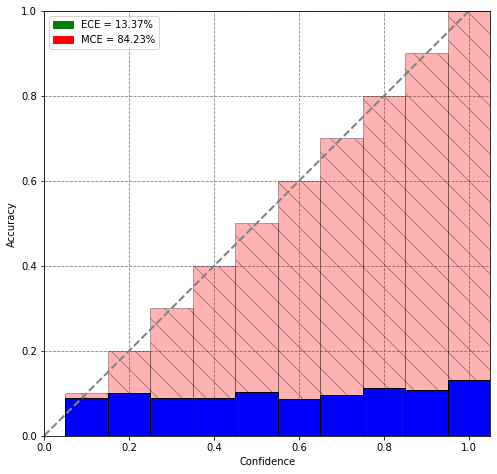

In [26]:
import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
  ECE, MCE = get_metrics(preds)
  bins, _, bin_accs, _, _ = calc_bins(preds)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  plt.legend(handles=[ECE_patch, MCE_patch])

  #plt.show()
  
  plt.savefig('calibrated_network.png', bbox_inches='tight')


### pre-calibration
draw_reliability_graph(preds)

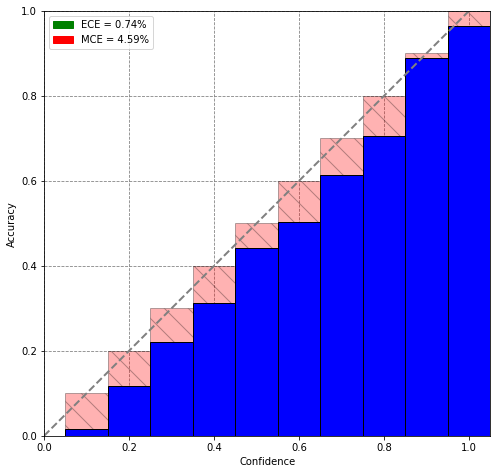

In [27]:
## temperature = 1.29
## post-calibration on validation
draw_reliability_graph(calibrated_preds)